In [1]:
import pandas as pd
import numpy as np
import annoy
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras
from keras.layers import Dense, Dropout, Flatten
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Reshape,UpSampling2D,Input,Lambda,Conv2DTranspose

In [3]:
transactions=pd.read_csv('transactions_train.csv')
print(transactions.shape)

(31788324, 5)


In [4]:
articles=pd.read_csv('articles.csv')
print(articles.shape)

(105542, 25)


In [6]:
article_data=pd.read_csv('articles_img_present.csv')
article_data.head()
ids=article_data['article_id']

In [20]:
images=pd.read_csv('img_pres.csv')

In [21]:
images=images.drop('Unnamed: 0',axis=1)
images.rename(columns={'0':'img_id'},inplace=True)
print(images.shape)
images.head()

(105100, 1)


,img_id
0,0108775015.jpg
1,0108775044.jpg
2,0108775051.jpg
3,0110065001.jpg
4,0110065002.jpg


In [22]:
images['path']=images['img_id'].apply(lambda x: f"images/{x[0:3]}/{x}")

In [23]:
images.head()

,img_id,path
0,0108775015.jpg,images/010/0108775015.jpg
1,0108775044.jpg,images/010/0108775044.jpg
2,0108775051.jpg,images/010/0108775051.jpg
3,0110065001.jpg,images/011/0110065001.jpg
4,0110065002.jpg,images/011/0110065002.jpg


In [7]:
ids=ids[0:5000]

In [8]:
articles=articles.loc[articles['article_id'].isin(ids)][['article_id','product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']]
articles.shape

(5000, 25)

In [9]:
transactions=transactions.loc[transactions['article_id'].isin(ids)][['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']]
transactions.shape

(2055732, 5)

In [10]:
test_data = transactions.groupby(by="customer_id")['article_id'].agg(list).reset_index()
test_data.head(25)

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[176209023]
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[351484002, 478646001, 351484002, 377277001, 3..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[351484002, 351484002]"
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[399061015, 399061015]"
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,[448509014]
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[349301001, 464454004, 413707001, 351933001, 4..."
6,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,"[308154005, 400456001, 453239043, 485552003]"
7,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[407354008, 347200001]"
8,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[373506019, 478298005, 403392002, 253448002, 3..."
9,0000f2ea26b7f0a9175f428c8cf7743e9e10e193465ecd...,"[436083003, 436083003]"


In [11]:
embeds=pd.read_csv('similarities.csv')
print(embeds.shape)
embeds.head()

(5000, 5001)


,path,images/010/0108775015.jpg,images/010/0108775044.jpg,images/010/0108775051.jpg,images/011/0110065001.jpg,images/011/0110065002.jpg,images/011/0110065011.jpg,images/011/0111565001.jpg,images/011/0111565003.jpg,images/011/0111586001.jpg,...,images/048/0489217007.jpg,images/048/0489435001.jpg,images/048/0489435002.jpg,images/048/0489435009.jpg,images/048/0489435010.jpg,images/048/0489435011.jpg,images/048/0489435012.jpg,images/048/0489435014.jpg,images/048/0489435015.jpg,images/048/0489435016.jpg
0,images/010/0108775015.jpg,1.000000,0.961681,0.974386,0.977738,0.961188,0.972273,0.941894,0.957899,0.956268,...,0.911624,0.951709,0.951384,0.954769,0.954861,0.950637,0.955816,0.947313,0.954170,0.945386
1,images/010/0108775044.jpg,0.961681,1.000000,0.978197,0.958795,0.993788,0.981855,0.962285,0.958465,0.963825,...,0.918834,0.980947,0.973577,0.976915,0.974529,0.977722,0.975748,0.953639,0.976721,0.961853
2,images/010/0108775051.jpg,0.974386,0.978197,1.000000,0.965839,0.975869,0.977835,0.948924,0.966358,0.962569,...,0.924103,0.970994,0.963249,0.966562,0.967037,0.969613,0.966992,0.957639,0.967525,0.961195
3,images/011/0110065001.jpg,0.977738,0.958795,0.965839,1.000000,0.966312,0.983325,0.943709,0.943825,0.946089,...,0.913624,0.958085,0.963144,0.962034,0.963686,0.957867,0.963485,0.949646,0.962482,0.949798
4,images/011/0110065002.jpg,0.961188,0.993788,0.975869,0.966312,1.000000,0.988004,0.962125,0.951366,0.954847,...,0.913356,0.986873,0.980306,0.981371,0.980496,0.983150,0.981786,0.955436,0.981588,0.965257


In [12]:
embeds.set_index('path',inplace=True)

In [25]:
test_data.customer_id.iloc[100]

'000b1981787a5d7c5353b6f4dd094442f3fc8e4f948e7fff592256c60e80c68c'

In [13]:
def retrieve_most_similar_products(idd):
    a=articles[articles['article_id']==idd].index.values.astype('int')
    print(idd,articles.loc[a,'product_type_name'])
    a='0'+str(idd)+'.jpg'
    b=images[images['img_id']==a].index.values.astype('int')
    print(a,b)
    given_img=images.loc[images['img_id']==a]['path'].item()
    original = load_img(given_img)
    plt.imshow(original)
    plt.show()
    print("most similar products:")

    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    closest_imgs_scores = embeds[given_img].sort_values(ascending=False)[1:5+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i],target_size=(224,224))
        s1=slice(66,76)
        target=closest_imgs[i][s1]
        plt.imshow(original)
        plt.show()
        print("similar article: ",target)

[176209023]
[176209023]
  products  article_ids
0   Hoodie  [176209023]
['176209023']
176209023 Series([], Name: product_type_name, dtype: object)
0176209023.jpg [98]


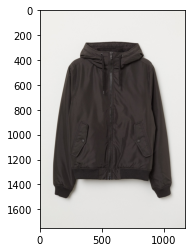

most similar products:


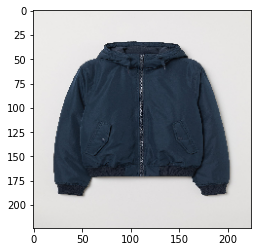

similar article:  


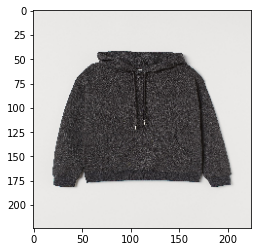

similar article:  


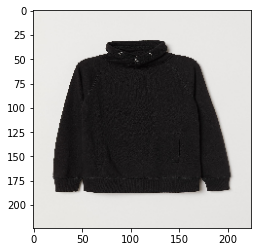

similar article:  


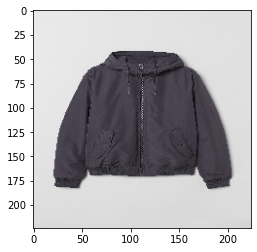

similar article:  


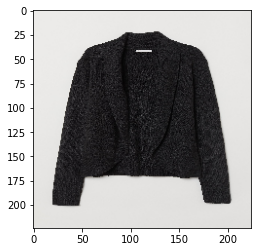

similar article:  


In [27]:
cust_id='00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'
index_pos=test_data[test_data['customer_id']==cust_id].index.values
arts=test_data.iloc[index_pos[0],1]
print(arts)
products=[]
items=[]
for a in arts:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)
print(items)
unique_items=pd.DataFrame()
unique_items['products']=pd.Series(products)
unique_items['article_ids']=pd.Series(items)
unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
print(unique_products.head())
final_list=[]
for i,j in zip(unique_products['products'],unique_products['article_ids']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)
for ids in final_list:
    idd = ids
    try:
        retrieve_most_similar_products(idd)
    except:
        print('iamge not there')